In [1]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
mnist = fetch_openml('mnist_784',version=1)
# mnist.keys()

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

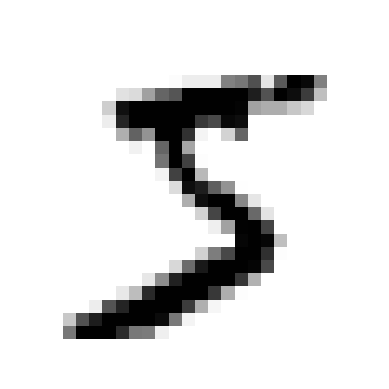

In [7]:
some_digit = X[X.index==0].values
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

'5'

As ML algorithms expect numbers and the label is a string, the label needs to be converted to integer

In [9]:
y = y.astype('uint8')

Split data into train and test  

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
# conver to True or False for number 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from joblib import parallel_backend
from sklearn.linear_model import SGDClassifier

with parallel_backend('threading', n_jobs=-1):
    sgd_clf = SGDClassifier(random_state=42)
    sgd_clf.fit(X_train, y_train_5)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(n_jobs=-1, random_state=42)

In [14]:
sgd_clf.predict(pd.DataFrame(some_digit))

/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

#### Measure accuracy using cross-validation

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy', n_jobs=-1)

array([0.95035, 0.96035, 0.9604 ])

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
any(dummy_clf.predict(X_train))

False

In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy', n_jobs=-1)

array([0.90965, 0.90965, 0.90965])

In [18]:
# alternative way to cross validaton
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if the data is not already shuffled

for train_index, test_index in skfolds.split(X_train, y_train_5):

    clone_clf = clone(sgd_clf)
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    accuracy = n_correct/len(y_pred)
    print(accuracy)

0.95035
0.96035
0.9604


#### Confusion Matrix

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [21]:
from sklearn.metrics import confusion_matrix

y_train_prefect_pred = y_train_5
confusion_matrix(y_train_5, y_train_prefect_pred)

array([[54579,     0],
       [    0,  5421]])

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision/Recall Trade-off

In [25]:
y_scores = sgd_clf.decision_function(some_digit)
y_scores

/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [27]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function', n_jobs=-1)
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [29]:
len(y_scores)

60000

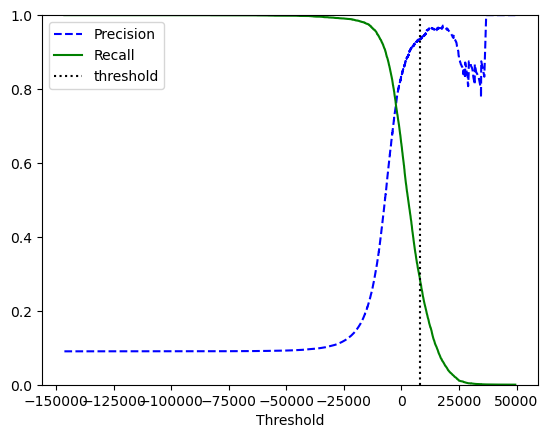

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


Text(0, 0.5, 'precision')

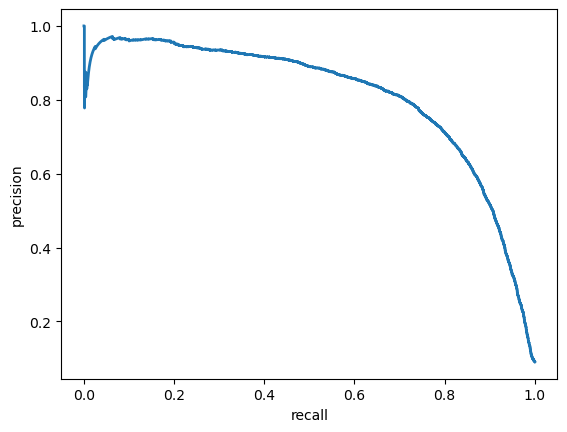

In [31]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel('recall')
plt.ylabel('precision')
# beautify the figure: add labels, grid, legend, arrow and text 
# plt.show()

In [32]:
# Returns the indices of the maximum values along an axis.
# In case of multiple occurrences of the maximum values, the indices corresponding to the first occurrence are returned.
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)] 
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### ROC Curve

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [36]:
idx_for_threshold_at_90 = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

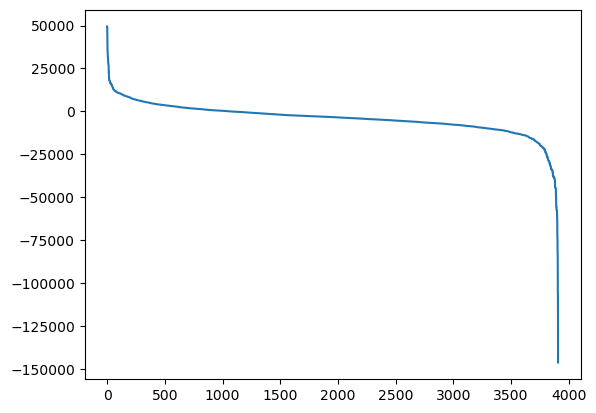

In [37]:
plt.plot(thresholds)

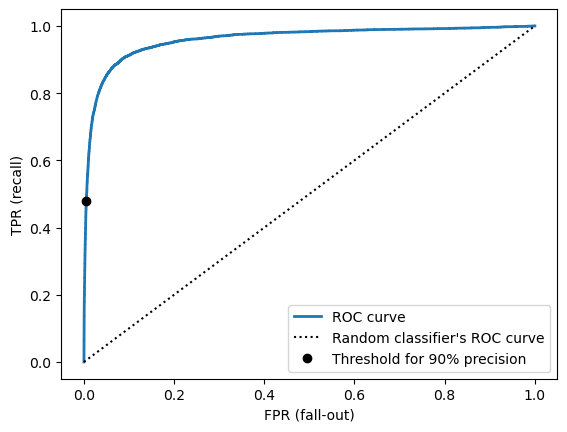

In [38]:
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0,1], [0,1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.ylabel("TPR (recall)")
plt.xlabel("FPR (fall-out)")
plt.legend()

### ROC AUC

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### RandomForestClassifier

In [40]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba', n_jobs=-1)

In [41]:
y_scores_forest = y_probas_forest[:, 1]

Text(0.5, 0, 'precision')

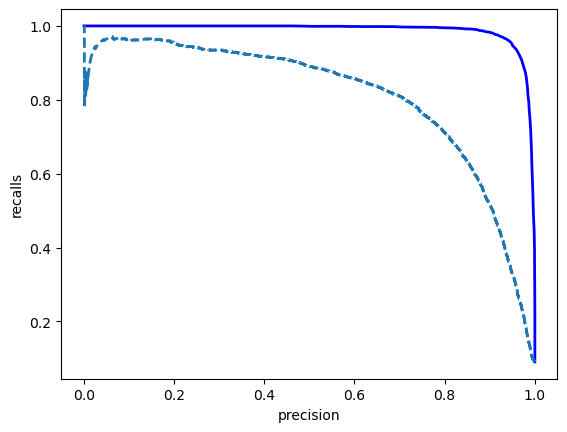

In [42]:
# the second column is the probability of the positve result
# in the random forest, the prediction would be -1 or 1
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.ylabel("recalls")
plt.xlabel("precision")

In [43]:
# score = proba of positive class 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [44]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
y_train_pred_forest

array([ True, False, False, ...,  True, False, False])

In [45]:
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

NameError: name 'plot_roc_curve' is not defined

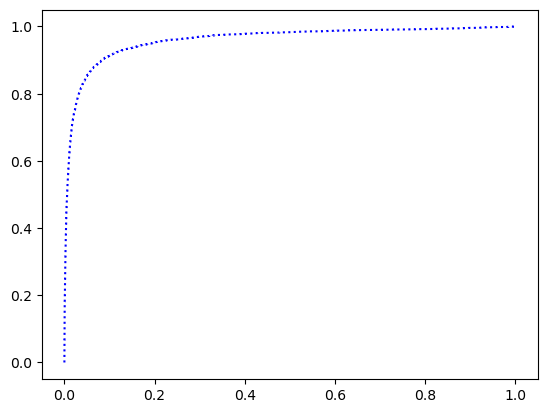

In [47]:
# plt.plot(fpr, tpr, "b:", label="SGD")
# plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
# plt.legend(loc="lower right")
# plt.show()

In [48]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [49]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [50]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

#### multiclass classification

In [51]:
from sklearn.svm import SVC 

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)
svm_clf.predict(some_digit)

/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [52]:
some_digit_scores = svm_clf.decision_function(some_digit)
some_digit_scores

/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [53]:
class_id = np.argmax(some_digit_scores)

In [54]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [55]:
svm_clf.classes_[class_id]

5

#### Force OneVsRestClassifier

In [56]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42), n_jobs=-1)
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42), n_jobs=-1)

In [57]:
ovr_clf.predict(some_digit)

/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/liu

array([5], dtype=uint8)

In [58]:
# check the number of classifier
len(ovr_clf.estimators_)

10

### Use scaler to improve prediction

In [59]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(some_digit)

/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [60]:
sgd_clf.decision_function(some_digit)

/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [61]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.87365, 0.85835, 0.8689 ])

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error analysis

In [63]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1)

In [64]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

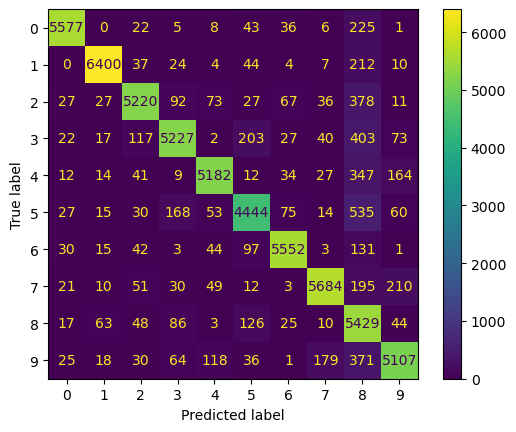

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

# fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
# plt.show()

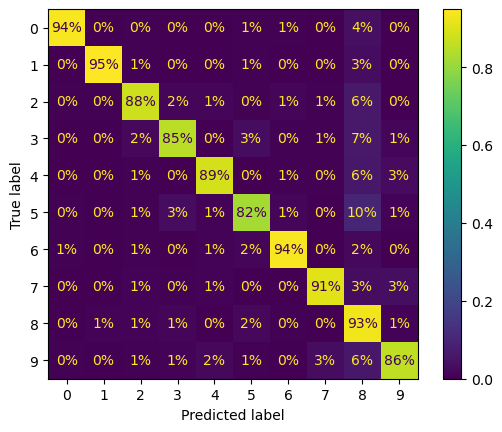

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format='.0%')
plt.show()

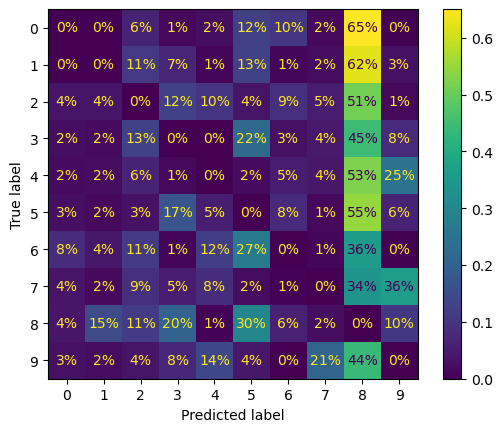

In [70]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, 
                                        normalize="true", values_format='.0%',
                                        sample_weight=sample_weight)
plt.show()

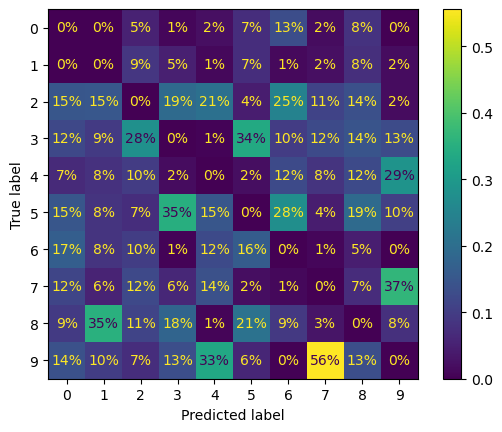

In [71]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, 
                                        normalize="pred", values_format='.0%',
                                        sample_weight=sample_weight)
plt.show()

#### Error rate

In [292]:
row_sums = conf_mx.sum(axis=1, keepdims=True) # axis=1 means sum rows
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

In [291]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

NameError: name 'norm_conf_mx' is not defined

In [293]:
np.fill_diagonal(norm_conf_mx, 0) #fill_diagonal is to fill the main diagonal as zero to highlight any misclassification
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

TypeError: 'tuple' object is not callable

### create classification and mis-classification

In [74]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [75]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


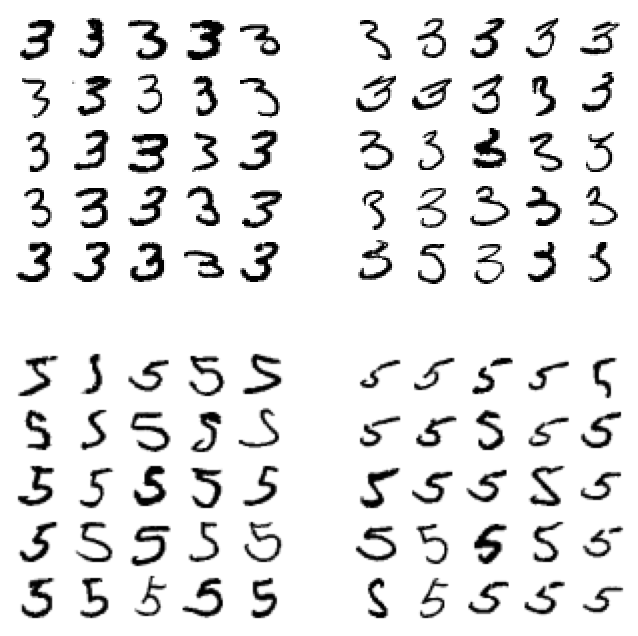

In [77]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

### Multilabel Classification

In [79]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(n_jobs=-1)

In [80]:
knn_clf.predict(some_digit)

/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[False,  True]])

In [81]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, a

0.976410265560605

### Multioutput Classification

In [169]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [167]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

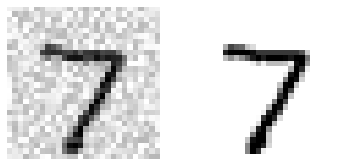

In [199]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[X_test_mod.index==60000].to_numpy())
plt.subplot(122); plot_digit(y_test_mod[y_test_mod.index==60000].to_numpy())
# save_fig("noisy_digit_example_plot")
plt.show()

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


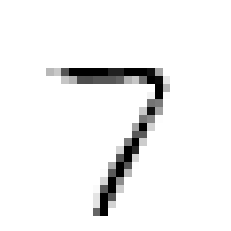

In [201]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test_mod[X_test_mod.index==60000].to_numpy())
plot_digit(clean_digit)
# save_fig("cleaned_digit_example_plot")